# Loss Analysis

sentence_transformers.losses define different loss functions, that can be used to fine-tune the network on training data. The loss function plays a critical role when fine-tuning the model. It determines how well our embedding model will work for the specific downstream task.

In [1]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, util, losses as loss
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import evaluation

from torch.utils.data import DataLoader
import torch

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split

import os, math
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
root = '.'
file_name = 'data/QQP/filteredQQP.csv'
seed = 77

df = pd.read_csv(os.path.join(root, file_name), header=0, sep=',', quotechar='"') \
    .loc[:, ['question1', 'question2', 'is_duplicate']] \
    .dropna()

X = df.drop('is_duplicate', axis=1)
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

train = X_train
val = X_val
test = X_test

train.loc[:, 'is_duplicate'] = y_train
val.loc[:, 'is_duplicate'] = y_val
test.loc[:, 'is_duplicate'] = y_test


print(train.shape, val.shape, test.shape)

(2111, 3) (905, 3) (1293, 3)


## Build Model

In [ ]:
class QuestionPredictor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 loss_func: str,
                 learning_rate: float,
                 epoch: int,
                 warmup_steps: int,
                 base_model: str,
                 batch_size: int,
                 val,
                 seed=seed,
                 ):
        self._learning_rate = learning_rate
        self._epoch = epoch
        self._warmup_steps = warmup_steps
        self._batch_size = batch_size

        self._seed = seed
        self._base_model = base_model
        self._model = SentenceTransformer(self._base_model)
        self._losses = {
            'CosineSimilarityLoss': loss.CosineSimilarityLoss(self._model),
            'MSELoss': loss.MSELoss(self._model),
        }

        self._val = val
        self._evaluator = EmbeddingSimilarityEvaluator(
            self._val.question1.tolist(),
            self._val.question2.tolist(),
            self._val.is_duplicate.tolist(),
        )


        self._loss_func = self._losses[loss_func]
        self._questions = None
        self._question_table = None

    def fit(self,x,y=None):
        df = x
        train_examples = df.apply(lambda row: InputExample(texts=[row[0], row[1]], label=float(row[2])), axis=1).tolist()

        train_dataset = SentencesDataset(train_examples, self._model)
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=self._batch_size)
        self._model.fit(train_objectives=[(train_dataloader, self._loss_func)], 
            evaluator=self._evaluator,
            epochs=self._epoch, 
            optimizer_params={
                'lr': self._learning_rate
            },
            warmup_steps=self._warmup_steps)

        # Compute embeddings
        file_name = 'data/who_covid_19_qa.csv'
        df_qa = pd.read_csv(os.path.join(root, file_name)).dropna()
        training_questions = df_qa.question.tolist()
        training_answers = df_qa.answer.tolist()

        train_embedding = self._model.encode(training_questions, convert_to_tensor=True)
        self._questions = training_questions
        self._answers = training_answers
        self._question_table = train_embedding
        return self


    def answer(self,x):
        # Compute embeddings
        saved_question = list()
        saved_answer = list()
        new_question = list()
        for sentence in x:
            test_embedding = self._model.encode(sentence, convert_to_tensor=True)
            
            # Compute cosine-similarities for each sentence pairs
            cosine_scores = util.pytorch_cos_sim(self._question_table, test_embedding)

            max_id = pd.Series(cosine_scores.numpy().reshape(-1).tolist()).idxmax()

            saved_question.append(self._questions[max_id])
            saved_answer.append(self._answers[max_id])
            new_question.append(sentence)

        return pd.DataFrame({
            'new_question': new_question,
            'matched_question': saved_question,
            'matched_answer': saved_answer,
        })

    def score(self, X=None, y=None, sample_weight=None):
        return self._evaluator(self._model)

    def get_params(self, deep=True):
        return {
            "base_model": self._base_model,
            "epoch": self._epoch,
            "warmup_steps": self._warmup_steps,
            "batch_size": self._batch_size,
            "learning_rate": self._learning_rate,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def save_model(self):
        file_name = '-'.join([str(e) for e in self.get_params().values()])
        torch.save(self._model, os.path.join(root, f'{file_name}.bot'))
        torch.save(self._question_table, os.path.join(root, f'{file_name}.pt'))

        
chatbot = QuestionPredictor(
    base_model='distilbert-base-nli-mean-tokens',
    loss_func='CosineSimilarityLoss',
    learning_rate=1e-5,
    epoch=1,
    batch_size=16,
    warmup_steps=100,
    val=val,
    seed=seed,
) \
.fit(train)

# chatbot.score()
# chatbot.save_model()
# question_pairs = chatbot.answer(test_set)
# question_pairs

## Loss Analisis

In [ ]:
class LossAnalyzer:
    def __init__(self, params: dict):
        self._params = params
        performance_list = pd.DataFrame({'dummy': [1]})
        for key, values in params.items():
            performance_list = pd.merge(performance_list, pd.DataFrame({key: values, 'dummy': [1] * len(values)}))
        performance_list.drop('dummy',axis=1, inplace=True)
        self._performance_list = performance_list
        self._performance_list.loc[:, 'loss'] = None

    @property
    def performance(self):
        return self._performance_list

    def scan(self):
        csv_name = 'test_parameter_combos.csv'
        col_names = self._performance_list.columns.tolist()
        csv = pd.read_csv(csv_name)
        self._performance_list = csv
        print(self._performance_list)
        display(self._performance_list)
        with open(csv_name, 'a') as f:
            f.write('\n')
        for idx, row in enumerate(self._performance_list.drop(['loss'], axis=1).iterrows()):
            if self._performance_list.loss.iloc[idx] and not math.isnan(self._performance_list.loss.iloc[idx]):
                continue
            param = row[1].to_dict()
            print('-'.join([str(e) for e in param.values()]))
            try:
                torch.cuda.empty_cache()
                chatbot = QuestionPredictor(
                    loss_func='CosineSimilarityLoss',
                    warmup_steps=100,
                    val=val,
                    seed=seed,
                    **param
                ) \
                .fit(train)
                chatbot.save_model()
                score = chatbot.score()

                perf_matrix = pd.DataFrame()
                self._performance_list.iloc[idx, len(self._performance_list.columns)-1] = score
                perf_matrix = perf_matrix.append(self._performance_list.iloc[idx])
                perf_matrix.columns = col_names
                perf_matrix.to_csv(csv_name, mode='a', header=False, index=False)
            except Exception as e:
                print(str(e))


params = {
    'base_model': [
                   'bert-base-nli-mean-tokens'
                   ],
    'learning_rate': [2.00E-03, 2.00E-05, 2.00E-07, 2.00E-09],
    'epoch': [1, 2, 3, 5, 10],
    'batch_size': [16, 32, 64]
}


analyzer = LossAnalyzer(params)
analyzer.scan()
analyzer.performance

                   base_model  batch_size  epoch  learning_rate    loss
0   bert-base-nli-mean-tokens          16      1   2.000000e-05  0.6659
1   bert-base-nli-mean-tokens          32      1   2.000000e-05  0.6301
2   bert-base-nli-mean-tokens          32      2   2.000000e-05  0.6838
3   bert-base-nli-mean-tokens          16      3   2.000000e-05  0.7145
4   bert-base-nli-mean-tokens          16      3   2.000000e-07  0.5005
5   bert-base-nli-mean-tokens          16      3   2.000000e-09  0.4868
6   bert-base-nli-mean-tokens          16      3   2.000000e-10  0.4868
7   bert-base-nli-mean-tokens          16      3   2.000000e-15  0.4868
8   bert-base-nli-mean-tokens          32      3   2.000000e-05  0.7002
9   bert-base-nli-mean-tokens          64      3   2.000000e-05  0.6847
10  bert-base-nli-mean-tokens          16      5   2.000000e-05  0.7103
11  bert-base-nli-mean-tokens          16     10   2.000000e-05  0.7210


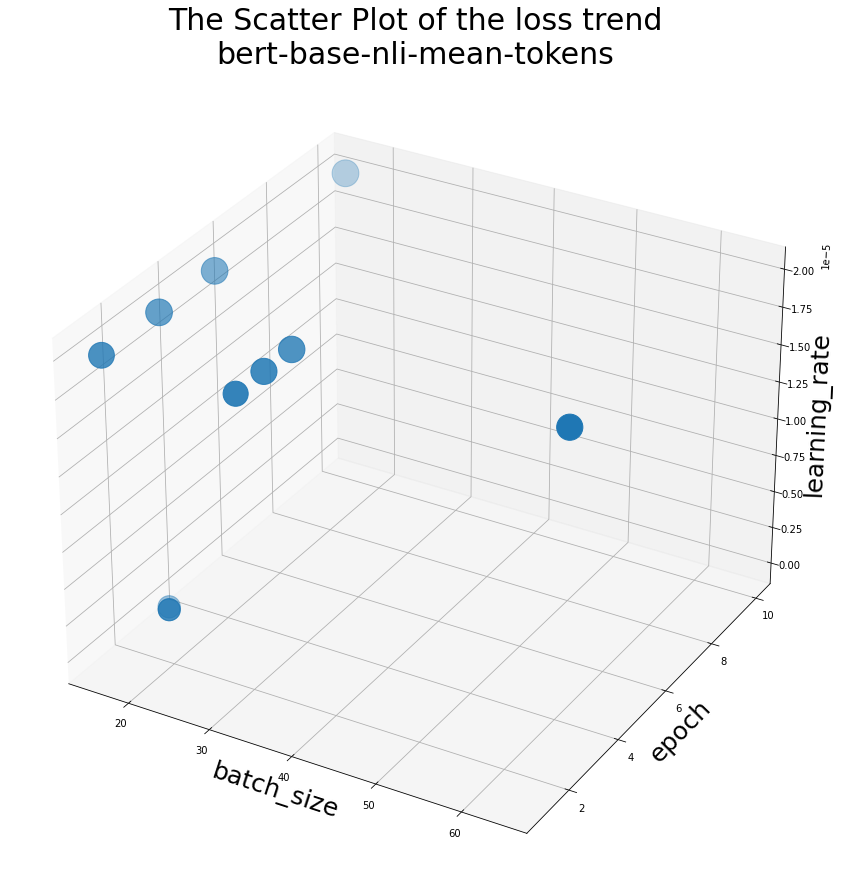

In [4]:
def plot_3d(df, model_type, col_x, col_y ,col_z, col_size, title):
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')

    df = df[df.base_model == model_type]
    print(df)
    xs = df.loc[:, col_x]
    ys = df.loc[:, col_y]
    zs = df.loc[:, col_z]
    ss = df.loc[:, col_size]*1000
    ax.scatter(xs, ys, zs, s=ss)

    ax.set_xlabel(col_x, fontsize=25)
    ax.set_ylabel(col_y, fontsize=25)
    ax.set_zlabel(col_z, fontsize=25)
    plt.title(title, fontsize=30)

    plt.show()

df_perf = pd.read_csv('loss/loss_analysis.csv')
plot_3d(df_perf,
        'bert-base-nli-mean-tokens',
        'batch_size', 'epoch', 'learning_rate', 'loss',
        'The Scatter Plot of the loss trend\nbert-base-nli-mean-tokens'
       )

                              base_model  batch_size  epoch  learning_rate  \
12  distilbert-base-nli-stsb-mean-tokens          16      1   2.000000e-05   
13  distilbert-base-nli-stsb-mean-tokens          32      1   2.000000e-05   
14  distilbert-base-nli-stsb-mean-tokens          32      2   2.000000e-05   
15  distilbert-base-nli-stsb-mean-tokens          16      3   2.000000e-05   
16  distilbert-base-nli-stsb-mean-tokens          16      3   2.000000e-07   
17  distilbert-base-nli-stsb-mean-tokens          16      3   2.000000e-09   
18  distilbert-base-nli-stsb-mean-tokens          16      3   2.000000e-10   
19  distilbert-base-nli-stsb-mean-tokens          16      3   2.000000e-15   
20  distilbert-base-nli-stsb-mean-tokens          32      3   2.000000e-05   
21  distilbert-base-nli-stsb-mean-tokens          64      3   2.000000e-05   
22  distilbert-base-nli-stsb-mean-tokens          16      5   2.000000e-05   
23  distilbert-base-nli-stsb-mean-tokens          16     10   2.

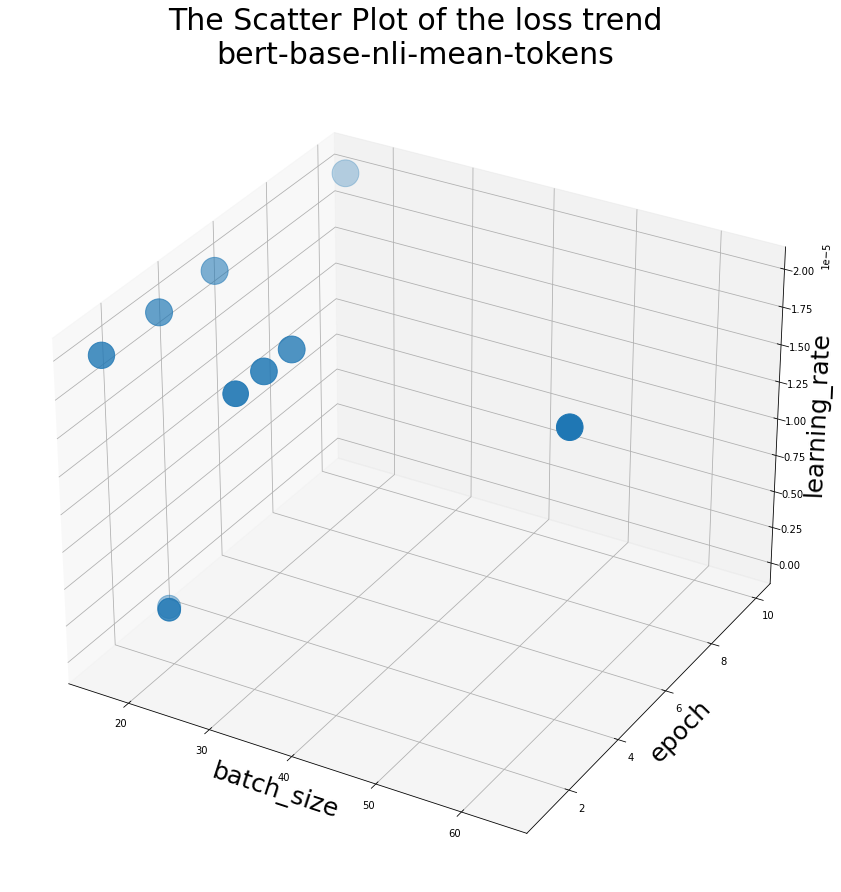

In [5]:
plot_3d(df_perf,
        'distilbert-base-nli-stsb-mean-tokens',
        'batch_size', 'epoch', 'learning_rate', 'loss',
        'The Scatter Plot of the loss trend\nbert-base-nli-mean-tokens'
       )

                      base_model  batch_size  epoch  learning_rate    loss
24  roberta-base-nli-mean-tokens          16      1   2.000000e-05  0.6625
25  roberta-base-nli-mean-tokens          32      1   2.000000e-05  0.6300
26  roberta-base-nli-mean-tokens          32      2   2.000000e-05  0.6789
27  roberta-base-nli-mean-tokens          16      3   2.000000e-05  0.6922
28  roberta-base-nli-mean-tokens          16      3   2.000000e-07  0.7049
29  roberta-base-nli-mean-tokens          16      3   2.000000e-09  0.4899
30  roberta-base-nli-mean-tokens          32      3   2.000000e-05  0.6879
31  roberta-base-nli-mean-tokens          64      3   2.000000e-05  0.6761
32  roberta-base-nli-mean-tokens          16      5   2.000000e-05  0.7064
33  roberta-base-nli-mean-tokens          16     10   2.000000e-05  0.7069


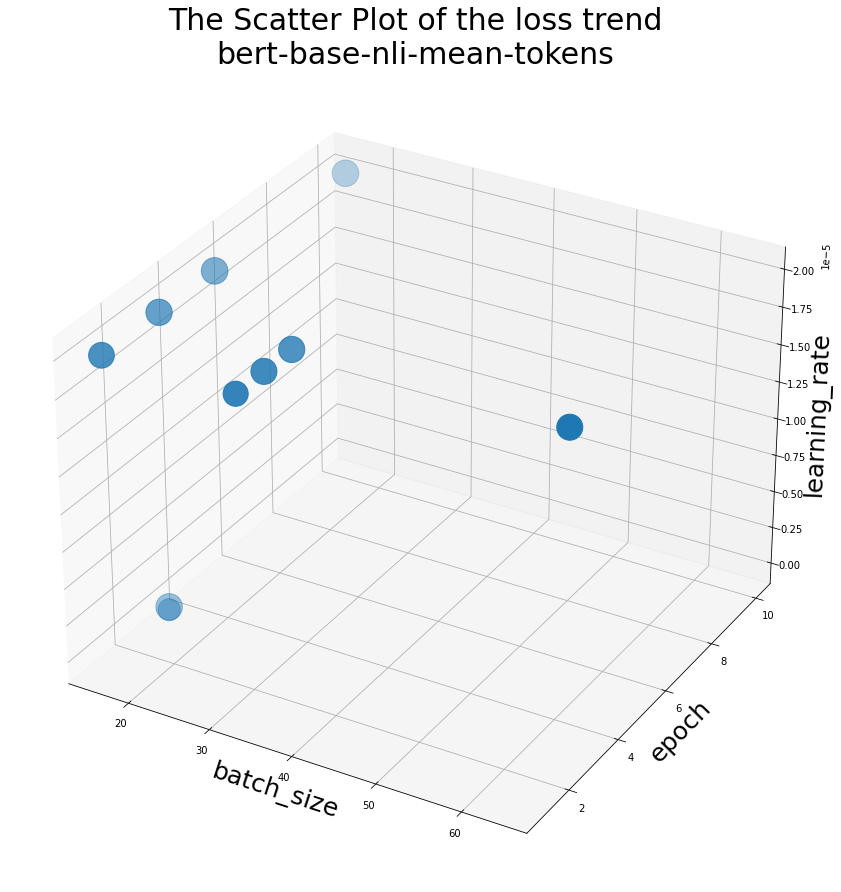

In [6]:
plot_3d(df_perf,
        'roberta-base-nli-mean-tokens',
        'batch_size', 'epoch', 'learning_rate', 'loss',
        'The Scatter Plot of the loss trend\nbert-base-nli-mean-tokens'
       )